## 安裝套件

In [10]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor                             #XGBoost Regressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import lightgbm as lgb                                       #LightGBM
from sklearn.model_selection import GridSearchCV             #Grid Search
from sklearn.ensemble import RandomForestRegressor           #Random Forest
from sklearn.linear_model import LogisticRegression          #Logistic Regression

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

## 匯入data

In [3]:
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
cats = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
train = pd.read_csv('competitive-data-science-predict-future-sales/sales_train_v2.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('competitive-data-science-predict-future-sales/test.csv').set_index('ID')

## 以下資料前處理與特徵選取皆參考至:
https://www.kaggle.com/dhimananubhav/feature-engineering-xgboost

# 1.Outlier處理

查看item_cnt_day和item_price的分布

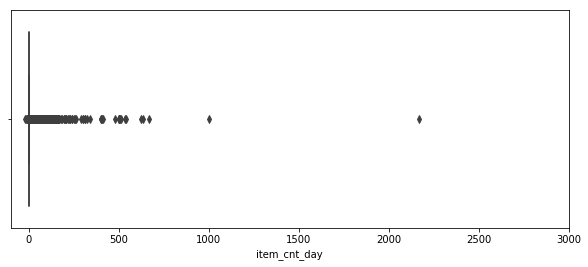

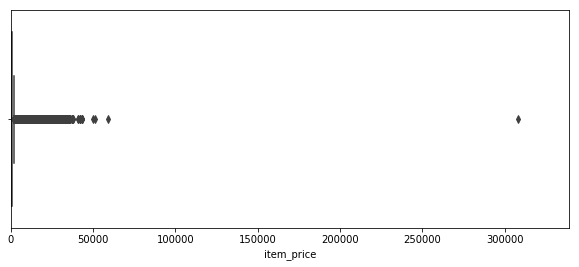

In [109]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

### 除去outlier以免影響模型(price>10000和sales>1000)

In [110]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

# 2.Missing Value處理

將price<0的不合理情形用同shop_id/同item_id/同data_block_num/item_price>0的中位數替代

In [111]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

修正有錯誤的shop_id

In [112]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [113]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

test的item, shop組合會有沒出現在train中的情形，表示train的銷售量為0，故將train增加筆數並補上0

In [114]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [37]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

10.474971055984497

In [38]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [39]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

4.634642839431763

# 3.增加feature

補上date_block_num=34，也就是要預測的2015年11月的筆數

In [40]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [41]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.19279265403747559

### Shops/Items/Cats features 

In [42]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.912867069244385

### Traget lags

In [43]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


In [44]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

29.41637110710144

### Mean encoded features

In [45]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

10.327449798583984

In [46]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.86150336265564

In [47]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

38.30161666870117

In [48]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.849035501480103

In [49]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.941097259521484

In [50]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.842651844024658

In [51]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.480675220489502

In [52]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.079691648483276

In [53]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.189361095428467

In [54]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.626266479492188

In [55]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


15.966309785842896

### Trend features
最後六個月的價格趨勢

In [56]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

301.5755457878113

最後一個月的店家收益趨勢

In [57]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

20.050748348236084

### 其他特徵

#### 月份

In [58]:
matrix['month'] = matrix['date_block_num'] % 12

#### 當月的天數

In [59]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [60]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

990.5863890647888

In [61]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

595.3668985366821

In [62]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.684757947921753

# 4.最後準備 
因為有加入前12個月的lag feature去作預測，故刪掉最前面12個月份的資料，以免發生資料不齊全的問題

In [63]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.1009485721588135

In [64]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

4.250424385070801

In [65]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [66]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

## 把處理好的資料存在data.pkl，以便下次載入

In [67]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [4]:
data = pd.read_pickle('data.pkl')

# 選擇features

一開始先嘗試全部變數放入模型中，再從XGBoost判斷出較為相關的因子進行篩選。

In [5]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    #'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    #'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    #'date_item_avg_item_cnt_lag_6',
    #'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    #'date_shop_avg_item_cnt_lag_6',
    #'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    #'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    #'date_city_avg_item_cnt_lag_1',
    #'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    #'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

將資料分割成train(第13~33個月)、valid(第33個月)、test(第34個月=最後要預測的)

In [7]:
X_train = data[data.date_block_num <= 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num <= 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [8]:
del data
gc.collect();

### 查看train/valid/test data格式與內容

In [99]:
X_train.head(1)

,date_block_num,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566,0.148071,0.0,-0.282715,0,31,1,1,12,12


In [100]:
Y_train.head(10)

4488710    0.0
4488711    0.0
4488712    0.0
4488713    1.0
4488714    1.0
4488715    0.0
4488716    0.0
4488717    0.0
4488718    0.0
4488719    0.0
Name: item_cnt_month, dtype: float16

In [101]:
X_valid.head(1)

,date_block_num,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
10675632,33,2,30,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.263672,0.069763,0.142822,0.093018,0.085083,0.25,0.157959,0.184448,0.143311,0.125122,0.138916,0.200928,0.058746,0.157959,0.0,-0.632324,9,31,1,1,32,32


In [102]:
Y_valid.head(10)

10675632    0.0
10675633    1.0
10675634    0.0
10675635    0.0
10675636    0.0
10675637    0.0
10675638    0.0
10675639    0.0
10675640    0.0
10675641    0.0
Name: item_cnt_month, dtype: float16

In [103]:
X_test.head(1)

,date_block_num,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
10913804,34,5,5037,3,19,5,10,0.0,1.0,3.0,1.0,1.0,0.258545,0.568359,2.511719,2.833984,1.977539,1.299805,0.190063,0.205933,0.245117,0.180054,0.206055,0.37915,0.513672,0.190063,0.0,-0.222046,10,30,1,1,14,14


# Models

## 1.XGBoost

In [83]:
ts = time.time()

xgboost = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

xgboost.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.15179	validation_1-rmse:1.11774
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10753	validation_1-rmse:1.08395
[2]	validation_0-rmse:1.06724	validation_1-rmse:1.05278
[3]	validation_0-rmse:1.03251	validation_1-rmse:1.02682
[4]	validation_0-rmse:1.00304	validation_1-rmse:1.00487
[5]	validation_0-rmse:0.978405	validation_1-rmse:0.988371
[6]	validation_0-rmse:0.957285	validation_1-rmse:0.973155
[7]	validation_0-rmse:0.939471	validation_1-rmse:0.962816
[8]	validation_0-rmse:0.924087	validation_1-rmse:0.952786
[9]	validation_0-rmse:0.911297	validation_1-rmse:0.9448
[10]	validation_0-rmse:0.900617	validation_1-rmse:0.938403
[11]	validation_0-rmse:0.891762	validation_1-rmse:0.932723
[12]	validation_0-rmse:0.883636	validation_1-rmse:0.928693
[13]	validation_0-rmse:0.877379	validation_1-rmse:0.925811
[14]	validation_0-rmse:0.871099	valid

2062.665502548218

In [84]:
Y_pred = xgboost.predict(X_valid).clip(0, 20)
Y_test = xgboost.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

用XGBoost跑出的結果最好的RMSE為0.91187，仍然無法超越 2019.4/23的最佳成績 0.90646。

### 查看對XGBoost模型影響的因子排名

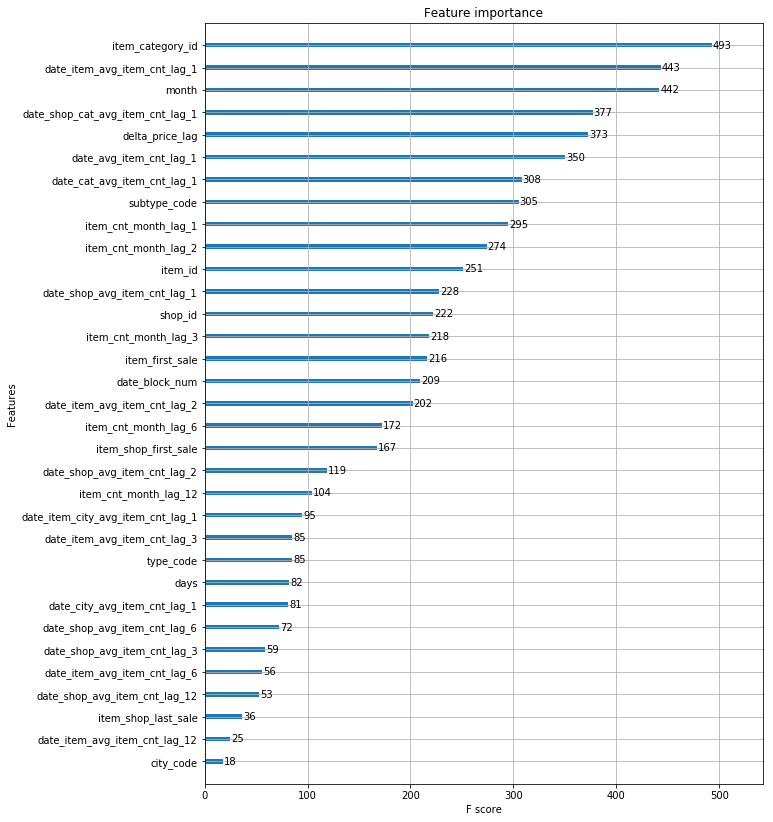

In [85]:
plot_features(xgboost, (10,14))

## 2.LightGBM

利用Grid Search來選出LightGBM最佳的參數組合。
因為程式要跑比較久，故這邊只篩選最佳的max_depth、num_leaves組合。

In [ ]:
ts = time.time()

parameters =  {
        'max_depth': range(5,15,2),
        'num_leaves': range(10,50,5),
        }
gbm = lgb.LGBMRegressor(objective='regression',
                        learning_rate =0.1, 
                        n_estimators = 100, 
                        min_child_weight = 1, 
                        subsample = 0.8,
                        colsample_bytree=0.8,
                        nthread = 7,)

gsearch = GridSearchCV(gbm, param_grid = parameters, cv = 5)
gsearch.fit(X_train, Y_train, 
            eval_metric = "rmse",
            eval_set = [(X_train, Y_train), (X_valid, Y_valid)],
            verbose = True,
            early_stopping_rounds = 10)

time.time() - ts

gsearch.best_params_, gsearch.best_score_

[1]	valid_0's l2: 1.29714	valid_0's rmse: 1.13892	valid_1's l2: 1.21135	valid_1's rmse: 1.10062
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20201	valid_0's rmse: 1.09636	valid_1's l2: 1.14486	valid_1's rmse: 1.06998
[3]	valid_0's l2: 1.12694	valid_0's rmse: 1.06158	valid_1's l2: 1.09344	valid_1's rmse: 1.04568
[4]	valid_0's l2: 1.06298	valid_0's rmse: 1.03101	valid_1's l2: 1.04769	valid_1's rmse: 1.02357
[5]	valid_0's l2: 1.01101	valid_0's rmse: 1.00549	valid_1's l2: 1.0103	valid_1's rmse: 1.00513
[6]	valid_0's l2: 0.967208	valid_0's rmse: 0.983467	valid_1's l2: 0.981977	valid_1's rmse: 0.990947
[7]	valid_0's l2: 0.930346	valid_0's rmse: 0.964544	valid_1's l2: 0.956186	valid_1's rmse: 0.977848
[8]	valid_0's l2: 0.900837	valid_0's rmse: 0.949125	valid_1's l2: 0.936551	valid_1's rmse: 0.967756
[9]	valid_0's l2: 0.876451	valid_0's rmse: 0.93619	valid_1's l2: 0.922663	valid_1's rmse: 0.960553
[10]	valid_0's l2: 0.856625	valid_0's rmse: 0.92554	valid_1'

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.30087	valid_0's rmse: 1.14056	valid_1's l2: 1.21583	valid_1's rmse: 1.10265
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20765	valid_0's rmse: 1.09893	valid_1's l2: 1.14775	valid_1's rmse: 1.07133
[3]	valid_0's l2: 1.13445	valid_0's rmse: 1.0651	valid_1's l2: 1.09688	valid_1's rmse: 1.04732
[4]	valid_0's l2: 1.07112	valid_0's rmse: 1.03495	valid_1's l2: 1.05132	valid_1's rmse: 1.02534
[5]	valid_0's l2: 1.01875	valid_0's rmse: 1.00933	valid_1's l2: 1.01493	valid_1's rmse: 1.00744
[6]	valid_0's l2: 0.975052	valid_0's rmse: 0.987447	valid_1's l2: 0.984609	valid_1's rmse: 0.992275
[7]	valid_0's l2: 0.938716	valid_0's rmse: 0.968873	valid_1's l2: 0.961005	valid_1's rmse: 0.980308
[8]	valid_0's l2: 0.908172	valid_0's rmse: 0.952981	valid_1's l2: 0.941832	valid_1's rmse: 0.970481
[9]	valid_0's l2: 0.883239	valid_0's rmse: 0.939808	valid_1's l2: 0.928014	valid_1's rmse: 0.963335
[10]	valid_0's l2: 0.862427	valid_0's rmse: 0.92867	valid_1

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.30155	valid_0's rmse: 1.14086	valid_1's l2: 1.21547	valid_1's rmse: 1.10248
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20876	valid_0's rmse: 1.09944	valid_1's l2: 1.1483	valid_1's rmse: 1.07159
[3]	valid_0's l2: 1.13569	valid_0's rmse: 1.06569	valid_1's l2: 1.09744	valid_1's rmse: 1.04759
[4]	valid_0's l2: 1.07311	valid_0's rmse: 1.03591	valid_1's l2: 1.05185	valid_1's rmse: 1.0256
[5]	valid_0's l2: 1.02128	valid_0's rmse: 1.01058	valid_1's l2: 1.01449	valid_1's rmse: 1.00722
[6]	valid_0's l2: 0.978125	valid_0's rmse: 0.989002	valid_1's l2: 0.984557	valid_1's rmse: 0.992249
[7]	valid_0's l2: 0.942082	valid_0's rmse: 0.970609	valid_1's l2: 0.961919	valid_1's rmse: 0.980775
[8]	valid_0's l2: 0.911181	valid_0's rmse: 0.954558	valid_1's l2: 0.941232	valid_1's rmse: 0.970171
[9]	valid_0's l2: 0.885959	valid_0's rmse: 0.941254	valid_1's l2: 0.925366	valid_1's rmse: 0.96196
[10]	valid_0's l2: 0.864963	valid_0's rmse: 0.930034	valid_1'

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29878	valid_0's rmse: 1.13964	valid_1's l2: 1.21372	valid_1's rmse: 1.10169
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20482	valid_0's rmse: 1.09764	valid_1's l2: 1.1464	valid_1's rmse: 1.0707
[3]	valid_0's l2: 1.13151	valid_0's rmse: 1.06372	valid_1's l2: 1.09649	valid_1's rmse: 1.04713
[4]	valid_0's l2: 1.06803	valid_0's rmse: 1.03346	valid_1's l2: 1.04988	valid_1's rmse: 1.02464
[5]	valid_0's l2: 1.01629	valid_0's rmse: 1.00811	valid_1's l2: 1.01365	valid_1's rmse: 1.0068
[6]	valid_0's l2: 0.971947	valid_0's rmse: 0.985874	valid_1's l2: 0.984039	valid_1's rmse: 0.991987
[7]	valid_0's l2: 0.936435	valid_0's rmse: 0.967696	valid_1's l2: 0.959346	valid_1's rmse: 0.979462
[8]	valid_0's l2: 0.905452	valid_0's rmse: 0.951552	valid_1's l2: 0.941526	valid_1's rmse: 0.970323
[9]	valid_0's l2: 0.880975	valid_0's rmse: 0.938603	valid_1's l2: 0.926242	valid_1's rmse: 0.962415
[10]	valid_0's l2: 0.860824	valid_0's rmse: 0.927806	valid_1'

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29914	valid_0's rmse: 1.1398	valid_1's l2: 1.21292	valid_1's rmse: 1.10133
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20496	valid_0's rmse: 1.09771	valid_1's l2: 1.14348	valid_1's rmse: 1.06933
[3]	valid_0's l2: 1.13036	valid_0's rmse: 1.06319	valid_1's l2: 1.09269	valid_1's rmse: 1.04532
[4]	valid_0's l2: 1.06636	valid_0's rmse: 1.03265	valid_1's l2: 1.04558	valid_1's rmse: 1.02254
[5]	valid_0's l2: 1.01493	valid_0's rmse: 1.00744	valid_1's l2: 1.00976	valid_1's rmse: 1.00487
[6]	valid_0's l2: 0.971394	valid_0's rmse: 0.985593	valid_1's l2: 0.980061	valid_1's rmse: 0.98998
[7]	valid_0's l2: 0.934874	valid_0's rmse: 0.966889	valid_1's l2: 0.954892	valid_1's rmse: 0.977186
[8]	valid_0's l2: 0.904696	valid_0's rmse: 0.951155	valid_1's l2: 0.937504	valid_1's rmse: 0.968248
[9]	valid_0's l2: 0.879835	valid_0's rmse: 0.937995	valid_1's l2: 0.923332	valid_1's rmse: 0.960902
[10]	valid_0's l2: 0.85922	valid_0's rmse: 0.926941	valid_1'

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29607	valid_0's rmse: 1.13845	valid_1's l2: 1.21079	valid_1's rmse: 1.10036
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20046	valid_0's rmse: 1.09566	valid_1's l2: 1.14369	valid_1's rmse: 1.06943
[3]	valid_0's l2: 1.1249	valid_0's rmse: 1.06061	valid_1's l2: 1.09187	valid_1's rmse: 1.04492
[4]	valid_0's l2: 1.0604	valid_0's rmse: 1.02976	valid_1's l2: 1.046	valid_1's rmse: 1.02274
[5]	valid_0's l2: 1.00782	valid_0's rmse: 1.0039	valid_1's l2: 1.00939	valid_1's rmse: 1.00468
[6]	valid_0's l2: 0.963566	valid_0's rmse: 0.981614	valid_1's l2: 0.980484	valid_1's rmse: 0.990194
[7]	valid_0's l2: 0.927293	valid_0's rmse: 0.96296	valid_1's l2: 0.956352	valid_1's rmse: 0.977933
[8]	valid_0's l2: 0.897157	valid_0's rmse: 0.947183	valid_1's l2: 0.934122	valid_1's rmse: 0.9665
[9]	valid_0's l2: 0.872456	valid_0's rmse: 0.934053	valid_1's l2: 0.919185	valid_1's rmse: 0.958741
[10]	valid_0's l2: 0.851806	valid_0's rmse: 0.922933	valid_1's l2:

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.2999	valid_0's rmse: 1.14013	valid_1's l2: 1.21516	valid_1's rmse: 1.10234
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20577	valid_0's rmse: 1.09808	valid_1's l2: 1.14886	valid_1's rmse: 1.07185
[3]	valid_0's l2: 1.13199	valid_0's rmse: 1.06395	valid_1's l2: 1.09743	valid_1's rmse: 1.04758
[4]	valid_0's l2: 1.06809	valid_0's rmse: 1.03349	valid_1's l2: 1.0518	valid_1's rmse: 1.02557
[5]	valid_0's l2: 1.0151	valid_0's rmse: 1.00752	valid_1's l2: 1.01451	valid_1's rmse: 1.00723
[6]	valid_0's l2: 0.971059	valid_0's rmse: 0.985423	valid_1's l2: 0.984796	valid_1's rmse: 0.992369
[7]	valid_0's l2: 0.934984	valid_0's rmse: 0.966946	valid_1's l2: 0.959567	valid_1's rmse: 0.979575
[8]	valid_0's l2: 0.904873	valid_0's rmse: 0.951248	valid_1's l2: 0.939798	valid_1's rmse: 0.969432
[9]	valid_0's l2: 0.879878	valid_0's rmse: 0.938018	valid_1's l2: 0.925571	valid_1's rmse: 0.962066
[10]	valid_0's l2: 0.859116	valid_0's rmse: 0.926885	valid_1'

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.30053	valid_0's rmse: 1.14041	valid_1's l2: 1.21451	valid_1's rmse: 1.10205
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20682	valid_0's rmse: 1.09855	valid_1's l2: 1.14737	valid_1's rmse: 1.07116
[3]	valid_0's l2: 1.13379	valid_0's rmse: 1.0648	valid_1's l2: 1.09711	valid_1's rmse: 1.04743
[4]	valid_0's l2: 1.06989	valid_0's rmse: 1.03436	valid_1's l2: 1.05025	valid_1's rmse: 1.02482
[5]	valid_0's l2: 1.01776	valid_0's rmse: 1.00884	valid_1's l2: 1.01321	valid_1's rmse: 1.00658
[6]	valid_0's l2: 0.973829	valid_0's rmse: 0.986828	valid_1's l2: 0.983131	valid_1's rmse: 0.99153
[7]	valid_0's l2: 0.937237	valid_0's rmse: 0.96811	valid_1's l2: 0.959445	valid_1's rmse: 0.979513
[8]	valid_0's l2: 0.906493	valid_0's rmse: 0.952099	valid_1's l2: 0.93922	valid_1's rmse: 0.969134
[9]	valid_0's l2: 0.881064	valid_0's rmse: 0.93865	valid_1's l2: 0.923724	valid_1's rmse: 0.961106
[10]	valid_0's l2: 0.860007	valid_0's rmse: 0.927366	valid_1's 

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29784	valid_0's rmse: 1.13923	valid_1's l2: 1.21312	valid_1's rmse: 1.10142
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20285	valid_0's rmse: 1.09675	valid_1's l2: 1.14541	valid_1's rmse: 1.07024
[3]	valid_0's l2: 1.12733	valid_0's rmse: 1.06176	valid_1's l2: 1.0928	valid_1's rmse: 1.04537
[4]	valid_0's l2: 1.06328	valid_0's rmse: 1.03116	valid_1's l2: 1.04844	valid_1's rmse: 1.02393
[5]	valid_0's l2: 1.01168	valid_0's rmse: 1.00582	valid_1's l2: 1.0122	valid_1's rmse: 1.00608
[6]	valid_0's l2: 0.967484	valid_0's rmse: 0.983608	valid_1's l2: 0.981482	valid_1's rmse: 0.990698
[7]	valid_0's l2: 0.931994	valid_0's rmse: 0.965398	valid_1's l2: 0.957103	valid_1's rmse: 0.978317
[8]	valid_0's l2: 0.9015	valid_0's rmse: 0.949474	valid_1's l2: 0.937285	valid_1's rmse: 0.968135
[9]	valid_0's l2: 0.876861	valid_0's rmse: 0.936408	valid_1's l2: 0.922437	valid_1's rmse: 0.960436
[10]	valid_0's l2: 0.856882	valid_0's rmse: 0.925679	valid_1's

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29815	valid_0's rmse: 1.13936	valid_1's l2: 1.21232	valid_1's rmse: 1.10105
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20314	valid_0's rmse: 1.09688	valid_1's l2: 1.14246	valid_1's rmse: 1.06886
[3]	valid_0's l2: 1.12802	valid_0's rmse: 1.06208	valid_1's l2: 1.09154	valid_1's rmse: 1.04477
[4]	valid_0's l2: 1.0638	valid_0's rmse: 1.03141	valid_1's l2: 1.04521	valid_1's rmse: 1.02236
[5]	valid_0's l2: 1.01098	valid_0's rmse: 1.00548	valid_1's l2: 1.00746	valid_1's rmse: 1.00372
[6]	valid_0's l2: 0.966755	valid_0's rmse: 0.983237	valid_1's l2: 0.976705	valid_1's rmse: 0.988284
[7]	valid_0's l2: 0.930406	valid_0's rmse: 0.964576	valid_1's l2: 0.956283	valid_1's rmse: 0.977897
[8]	valid_0's l2: 0.899436	valid_0's rmse: 0.948386	valid_1's l2: 0.937059	valid_1's rmse: 0.968018
[9]	valid_0's l2: 0.874638	valid_0's rmse: 0.935221	valid_1's l2: 0.922428	valid_1's rmse: 0.960431
[10]	valid_0's l2: 0.85471	valid_0's rmse: 0.924505	valid_1

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29526	valid_0's rmse: 1.1381	valid_1's l2: 1.21017	valid_1's rmse: 1.10008
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.19915	valid_0's rmse: 1.09506	valid_1's l2: 1.14322	valid_1's rmse: 1.06921
[3]	valid_0's l2: 1.12066	valid_0's rmse: 1.05861	valid_1's l2: 1.0905	valid_1's rmse: 1.04427
[4]	valid_0's l2: 1.05636	valid_0's rmse: 1.02779	valid_1's l2: 1.04533	valid_1's rmse: 1.02241
[5]	valid_0's l2: 1.00367	valid_0's rmse: 1.00183	valid_1's l2: 1.00777	valid_1's rmse: 1.00388
[6]	valid_0's l2: 0.959311	valid_0's rmse: 0.979444	valid_1's l2: 0.978966	valid_1's rmse: 0.989427
[7]	valid_0's l2: 0.922108	valid_0's rmse: 0.960265	valid_1's l2: 0.953096	valid_1's rmse: 0.976266
[8]	valid_0's l2: 0.891432	valid_0's rmse: 0.944157	valid_1's l2: 0.932516	valid_1's rmse: 0.965669
[9]	valid_0's l2: 0.866485	valid_0's rmse: 0.930852	valid_1's l2: 0.917954	valid_1's rmse: 0.958099
[10]	valid_0's l2: 0.846878	valid_0's rmse: 0.92026	valid_1'

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29915	valid_0's rmse: 1.1398	valid_1's l2: 1.21483	valid_1's rmse: 1.10219
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20428	valid_0's rmse: 1.0974	valid_1's l2: 1.14822	valid_1's rmse: 1.07155
[3]	valid_0's l2: 1.12997	valid_0's rmse: 1.063	valid_1's l2: 1.09625	valid_1's rmse: 1.04702
[4]	valid_0's l2: 1.06562	valid_0's rmse: 1.03229	valid_1's l2: 1.05041	valid_1's rmse: 1.02489
[5]	valid_0's l2: 1.01252	valid_0's rmse: 1.00624	valid_1's l2: 1.01281	valid_1's rmse: 1.00638
[6]	valid_0's l2: 0.968094	valid_0's rmse: 0.983918	valid_1's l2: 0.983293	valid_1's rmse: 0.991611
[7]	valid_0's l2: 0.931426	valid_0's rmse: 0.965104	valid_1's l2: 0.956918	valid_1's rmse: 0.978222
[8]	valid_0's l2: 0.900614	valid_0's rmse: 0.949007	valid_1's l2: 0.936504	valid_1's rmse: 0.967732
[9]	valid_0's l2: 0.875499	valid_0's rmse: 0.935681	valid_1's l2: 0.921759	valid_1's rmse: 0.960083
[10]	valid_0's l2: 0.854517	valid_0's rmse: 0.924401	valid_1's

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29977	valid_0's rmse: 1.14007	valid_1's l2: 1.21409	valid_1's rmse: 1.10186
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20486	valid_0's rmse: 1.09766	valid_1's l2: 1.14513	valid_1's rmse: 1.07011
[3]	valid_0's l2: 1.13138	valid_0's rmse: 1.06366	valid_1's l2: 1.09447	valid_1's rmse: 1.04617
[4]	valid_0's l2: 1.06746	valid_0's rmse: 1.03318	valid_1's l2: 1.04874	valid_1's rmse: 1.02408
[5]	valid_0's l2: 1.0144	valid_0's rmse: 1.00718	valid_1's l2: 1.01073	valid_1's rmse: 1.00535
[6]	valid_0's l2: 0.969927	valid_0's rmse: 0.984849	valid_1's l2: 0.9803	valid_1's rmse: 0.990101
[7]	valid_0's l2: 0.93277	valid_0's rmse: 0.9658	valid_1's l2: 0.956717	valid_1's rmse: 0.978119
[8]	valid_0's l2: 0.901193	valid_0's rmse: 0.949312	valid_1's l2: 0.932565	valid_1's rmse: 0.965694
[9]	valid_0's l2: 0.875774	valid_0's rmse: 0.935828	valid_1's l2: 0.916645	valid_1's rmse: 0.957416
[10]	valid_0's l2: 0.854484	valid_0's rmse: 0.924383	valid_1's l

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29704	valid_0's rmse: 1.13888	valid_1's l2: 1.21243	valid_1's rmse: 1.1011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.2012	valid_0's rmse: 1.09599	valid_1's l2: 1.14392	valid_1's rmse: 1.06954
[3]	valid_0's l2: 1.1242	valid_0's rmse: 1.06028	valid_1's l2: 1.09073	valid_1's rmse: 1.04438
[4]	valid_0's l2: 1.05996	valid_0's rmse: 1.02955	valid_1's l2: 1.0462	valid_1's rmse: 1.02284
[5]	valid_0's l2: 1.0082	valid_0's rmse: 1.00409	valid_1's l2: 1.00942	valid_1's rmse: 1.0047
[6]	valid_0's l2: 0.963965	valid_0's rmse: 0.981817	valid_1's l2: 0.979011	valid_1's rmse: 0.98945
[7]	valid_0's l2: 0.927608	valid_0's rmse: 0.963124	valid_1's l2: 0.953979	valid_1's rmse: 0.976718
[8]	valid_0's l2: 0.897011	valid_0's rmse: 0.947107	valid_1's l2: 0.934529	valid_1's rmse: 0.96671
[9]	valid_0's l2: 0.872269	valid_0's rmse: 0.933954	valid_1's l2: 0.919584	valid_1's rmse: 0.958949
[10]	valid_0's l2: 0.852086	valid_0's rmse: 0.923085	valid_1's l2:

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29745	valid_0's rmse: 1.13906	valid_1's l2: 1.21206	valid_1's rmse: 1.10094
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20178	valid_0's rmse: 1.09626	valid_1's l2: 1.14307	valid_1's rmse: 1.06914
[3]	valid_0's l2: 1.1249	valid_0's rmse: 1.06061	valid_1's l2: 1.09164	valid_1's rmse: 1.04482
[4]	valid_0's l2: 1.05993	valid_0's rmse: 1.02953	valid_1's l2: 1.04395	valid_1's rmse: 1.02174
[5]	valid_0's l2: 1.007	valid_0's rmse: 1.00349	valid_1's l2: 1.00631	valid_1's rmse: 1.00315
[6]	valid_0's l2: 0.962693	valid_0's rmse: 0.981169	valid_1's l2: 0.975404	valid_1's rmse: 0.987626
[7]	valid_0's l2: 0.925041	valid_0's rmse: 0.96179	valid_1's l2: 0.954015	valid_1's rmse: 0.976737
[8]	valid_0's l2: 0.894066	valid_0's rmse: 0.94555	valid_1's l2: 0.933818	valid_1's rmse: 0.966343
[9]	valid_0's l2: 0.869575	valid_0's rmse: 0.93251	valid_1's l2: 0.919994	valid_1's rmse: 0.959163
[10]	valid_0's l2: 0.848343	valid_0's rmse: 0.921055	valid_1's l

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29455	valid_0's rmse: 1.13778	valid_1's l2: 1.21003	valid_1's rmse: 1.10001
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.19768	valid_0's rmse: 1.09439	valid_1's l2: 1.14163	valid_1's rmse: 1.06847
[3]	valid_0's l2: 1.11855	valid_0's rmse: 1.05762	valid_1's l2: 1.08841	valid_1's rmse: 1.04327
[4]	valid_0's l2: 1.05428	valid_0's rmse: 1.02678	valid_1's l2: 1.04194	valid_1's rmse: 1.02075
[5]	valid_0's l2: 1.00141	valid_0's rmse: 1.00071	valid_1's l2: 1.00577	valid_1's rmse: 1.00288
[6]	valid_0's l2: 0.957611	valid_0's rmse: 0.978576	valid_1's l2: 0.974727	valid_1's rmse: 0.987282
[7]	valid_0's l2: 0.921883	valid_0's rmse: 0.960147	valid_1's l2: 0.947805	valid_1's rmse: 0.973553
[8]	valid_0's l2: 0.891077	valid_0's rmse: 0.943969	valid_1's l2: 0.92736	valid_1's rmse: 0.962995
[9]	valid_0's l2: 0.865576	valid_0's rmse: 0.930364	valid_1's l2: 0.912415	valid_1's rmse: 0.955204
[10]	valid_0's l2: 0.84562	valid_0's rmse: 0.919576	valid_1

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[1]	valid_0's l2: 1.29839	valid_0's rmse: 1.13947	valid_1's l2: 1.21442	valid_1's rmse: 1.10201
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 1.20303	valid_0's rmse: 1.09683	valid_1's l2: 1.14749	valid_1's rmse: 1.07121
[3]	valid_0's l2: 1.12698	valid_0's rmse: 1.06159	valid_1's l2: 1.09383	valid_1's rmse: 1.04586
[4]	valid_0's l2: 1.06243	valid_0's rmse: 1.03074	valid_1's l2: 1.04962	valid_1's rmse: 1.02451
[5]	valid_0's l2: 1.00845	valid_0's rmse: 1.00421	valid_1's l2: 1.01107	valid_1's rmse: 1.00552
[6]	valid_0's l2: 0.963984	valid_0's rmse: 0.981827	valid_1's l2: 0.980365	valid_1's rmse: 0.990134
[7]	valid_0's l2: 0.927043	valid_0's rmse: 0.962831	valid_1's l2: 0.956016	valid_1's rmse: 0.977761
[8]	valid_0's l2: 0.896318	valid_0's rmse: 0.946741	valid_1's l2: 0.935736	valid_1's rmse: 0.967334
[9]	valid_0's l2: 0.870756	valid_0's rmse: 0.933143	valid_1's l2: 0.921387	valid_1's rmse: 0.959889
[10]	valid_0's l2: 0.849886	valid_0's rmse: 0.921893	valid

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


#### 印出最佳max_depth、num_leaves參數組合

In [122]:
gsearch.best_params_, gsearch.best_score_

({'max_depth': 11, 'num_leaves': 40}, 0.47523879328069474)

In [157]:
ts = time.time()

gbm = lgb.LGBMRegressor(objective='regression',
                        max_depth=11,
                        num_leaves=40,
                        learning_rate=0.05,
                        n_estimators=100)
gbm.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 50)

time.time() - ts

[1]	training's l2: 1.35213	training's rmse: 1.16281	valid_1's l2: 1.25022	valid_1's rmse: 1.11813
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 1.29815	training's rmse: 1.13937	valid_1's l2: 1.21234	valid_1's rmse: 1.10106
[3]	training's l2: 1.24928	training's rmse: 1.11771	valid_1's l2: 1.17862	valid_1's rmse: 1.08564
[4]	training's l2: 1.20492	training's rmse: 1.09769	valid_1's l2: 1.14805	valid_1's rmse: 1.07147
[5]	training's l2: 1.16479	training's rmse: 1.07926	valid_1's l2: 1.11972	valid_1's rmse: 1.05817
[6]	training's l2: 1.12842	training's rmse: 1.06227	valid_1's l2: 1.09543	valid_1's rmse: 1.04663
[7]	training's l2: 1.09543	training's rmse: 1.04663	valid_1's l2: 1.0722	valid_1's rmse: 1.03547
[8]	training's l2: 1.06528	training's rmse: 1.03212	valid_1's l2: 1.05114	valid_1's rmse: 1.02525
[9]	training's l2: 1.03809	training's rmse: 1.01887	valid_1's l2: 1.03235	valid_1's rmse: 1.01605
[10]	training's l2: 1.01315	training's rmse: 1.00655	vali

[81]	training's l2: 0.693673	training's rmse: 0.83287	valid_1's l2: 0.84123	valid_1's rmse: 0.917186
[82]	training's l2: 0.692333	training's rmse: 0.832065	valid_1's l2: 0.843817	valid_1's rmse: 0.918595
[83]	training's l2: 0.691511	training's rmse: 0.831571	valid_1's l2: 0.843641	valid_1's rmse: 0.918499
[84]	training's l2: 0.690904	training's rmse: 0.831207	valid_1's l2: 0.843884	valid_1's rmse: 0.918631
[85]	training's l2: 0.690324	training's rmse: 0.830857	valid_1's l2: 0.843778	valid_1's rmse: 0.918574
[86]	training's l2: 0.689732	training's rmse: 0.830501	valid_1's l2: 0.844064	valid_1's rmse: 0.918729
[87]	training's l2: 0.68917	training's rmse: 0.830162	valid_1's l2: 0.84382	valid_1's rmse: 0.918597
[88]	training's l2: 0.688579	training's rmse: 0.829807	valid_1's l2: 0.843533	valid_1's rmse: 0.918441
[89]	training's l2: 0.687912	training's rmse: 0.829405	valid_1's l2: 0.843384	valid_1's rmse: 0.918359
[90]	training's l2: 0.687311	training's rmse: 0.829042	valid_1's l2: 0.842862

80.3467972278595

In [81]:
Y_pred = gbm.predict(X_valid).clip(0, 20)
Y_test = gbm.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission2.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('gbm_train2.pickle', 'wb'))
pickle.dump(Y_test, open('gbm_test2.pickle', 'wb'))

但是用最佳參數組合跑出的結果最好的RMSE為0.91841，仍然無法超越 2019.4/23的最佳成績 0.90646。

## 3.Random Forest

In [158]:
rf = RandomForestRegressor(n_estimators=50, random_state=20190513, n_jobs=6)

In [159]:
ts = time.time()
rf.fit(X_train, Y_train)
time.time() - ts

d:\python\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


1416.891346693039

In [160]:
Y_pred = rf.predict(X_valid).clip(0, 20)
Y_test = rf.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('rf_submission3.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('rf_train3.pickle', 'wb'))
pickle.dump(Y_test, open('rf_test3.pickle', 'wb'))

用Random Forest跑出的最好的RMSE為0.96645。